# Cuidado! Lluvia de Hamburguesas
## Análisis con random forest

### Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

### Configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import crear_archivo_predicciones
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from preprocessing import manejo_missing_values
from preprocessing import aplicarOneHot
from preprocessing import estandarizar

In [2]:
x,y = obtener_training_set()
x = aplicarOneHot(x)
x_val, y_val = obtener_valdev_set()
x_val = aplicarOneHot(x_val)

## Random Forest

Es una técnica que parte de bagging. Se divide el set de datos en distintos subsets. Entrenamos un modelo con cada set y construimos un único modelo predictivo a partir de los anteriores. La particularidad de random forest es que los atributos elegidos como importantes son un conjunto de m atributos al azar.

Los hiperparametros a definir son los mismos que los del árbol de decisión, mas la cantidad de modelos a entrenar
* Criterio: El criterio con el cual se determina la pureza de un nodo. Determinaremos el mejor entre gini y entropy
* Maxima profundidad: Es la longitud máxima que puede tener alguna rama partiendo de la raíz. Utilizaremos profundidad 4 para mantener a los modelos simples.
* Min Sample Leaf: Es la cantidad minima de instancias que debe tener un nodo para poder existir.
* Cantidad de arboles a entrenar : Dejaremos el default(100).

En primer lugar utilizaremos como preprocesamiento el transformar todas las variables categoricas con one hot encoding.
A partir de eso, se trabajará en un modelo estandarizado(al que se le resta el promedio a cada feature y se lo divide por el desvio estandar) y otro sin estandarizar. Ya sacamos un 10% de los datos para el hold-out con el cual verificaremos el mejor modelo que encontremos y con el resto haremos un 5-fold estratificado respetando el hecho de que porcentualmente el dia no target cubre casi un 80% de todos los datos.

Empezamos por el arbol sin estandarizar. Para cada ronda de k-fold buscaremos sus mejores parametros y obtendremos el accuracy promedio. Finalmente nos quedamos con los mejores parametros del mejor fold.

In [3]:
kf = StratifiedKFold(n_splits=5, random_state=119, shuffle=True)
forest_uno = RandomForestClassifier()
forest_uno = GridSearchCV(forest_uno, {'criterion':('gini', 'entropy'), 'max_depth':[9,10,11,12,13] ,'min_samples_leaf':[100,120,150,170]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
forest_uno.fit(x, y.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [9, 10, 11, 12, 13],
                         'min_samples_leaf': [100, 120, 150, 170]},
             scoring='roc_auc')

In [4]:
resultados = pd.DataFrame(forest_uno.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_criterion','param_max_depth', 'param_min_samples_leaf','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,mean_score_time
32,1,entropy,12,100,0.860516,0.292241
36,2,entropy,13,100,0.860155,0.303125
28,3,entropy,11,100,0.859532,0.276878
37,4,entropy,13,120,0.859152,0.273487
12,5,gini,12,100,0.858729,0.275147


Ahora veamos el arbol con el dataset estandarizado

In [5]:
x_estandarizado = estandarizar(x.copy(), x.copy())
kf = StratifiedKFold(n_splits=5, random_state=119, shuffle=True)
forest_dos = RandomForestClassifier()
forest_dos = GridSearchCV(forest_dos, {'criterion':('gini', 'entropy'), 'max_depth':[9,10,11,12,13] ,'min_samples_leaf':[100,120,150,170]}, n_jobs = -1, cv = kf, scoring ='roc_auc')
forest_dos.fit(x_estandarizado, y.values.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [9, 10, 11, 12, 13],
                         'min_samples_leaf': [100, 120, 150, 170]},
             scoring='roc_auc')

In [6]:
resultados = pd.DataFrame(forest_dos.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_criterion','param_max_depth', 'param_min_samples_leaf','mean_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,mean_score_time
36,1,entropy,13,100,0.860319,0.274891
32,2,entropy,12,100,0.859683,0.285958
28,3,entropy,11,100,0.859679,0.294088
37,4,entropy,13,120,0.859289,0.289646
16,5,gini,13,100,0.858928,0.305932


Se puede ver que consiguen un porcentaje bastance similar en cuanto a la certeza obtenida de ambos preprocesamientos. Utilizaremos el dataset sin estandarizar con los mejores parametros encontrados para mantener el preprocesamiento lo más simple posible.

In [5]:
forest_final = forest_uno.best_estimator_
forest_final.fit(x, y.values.ravel())

RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=100)

### Visualizamos uno de los árboles con los mejores hiperparametros obtenidos:

In [8]:
dot_data = tree.export_graphviz(forest_final.estimators_[20], class_names=["Lloverán", "No lloverán"], feature_names=x.columns) 
graph = graphviz.Source(dot_data, format='png')
graph.render("ArbolForest")

'ArbolForest.png'

El arbol es muy grande para mostrarlo en el notebook pero lo dejaremos en el directorio. En el mismo se observa que el feature raíz elegido no es el mismo que en el primer modelo de árbol de decisión. Esto se debe a que dentro de los m features elegidos para este arbol, la humedad tarde quedó afuera, entonces el feature más relevante entre los escogidos fue la velocidad viento temprano. 

### Matriz de confusión



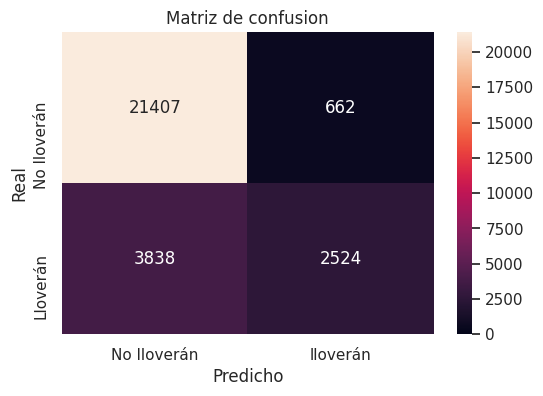

In [9]:
predicciones = forest_final.predict(x_val)
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [10]:
accuracy_score = accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy_score)

ACCURACY SCORE:  0.8417220639442862


#### Precision y Recall 



In [11]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.7922159447583177 
RECALL:  0.3967305878654511


#### F1 Score

In [12]:
f1_score = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1_score)

F1 SCORE:  0.5286971093422708


Podemos observar algo parecido a el árbol de decisión. A pesar de tener un accuracy respetable, la matriz de confusión muestra que el modelo no es tan bueno pues de la diagonal principal se ve una gran cantidad false negatives, muy por encima de los true positives.
* Del total de dias que lloverán en el dataset(5726), solo logró prededir a 2205 de ellos(menos que la mitad)
* Del total de dias que no lloverán en el dataset(19863), logró prededir a 19244 de ellos(casi la totalidad)
* Del total de predichos como que lloverán (2824), en 2205 de ellos realmente iba a llover al dia siguiente.

Utilizando las formulas correspondientes vemos que tiene una Precisión del 78%(bastante decente), pero como es de esperar, un Recall del 38%, demasiado bajo. También tiene una especificidad del 96%. Esto quiere decir que de los dias que sí llovio, ni la mitad conseguimos predecir correctamente.

### Curva ROC

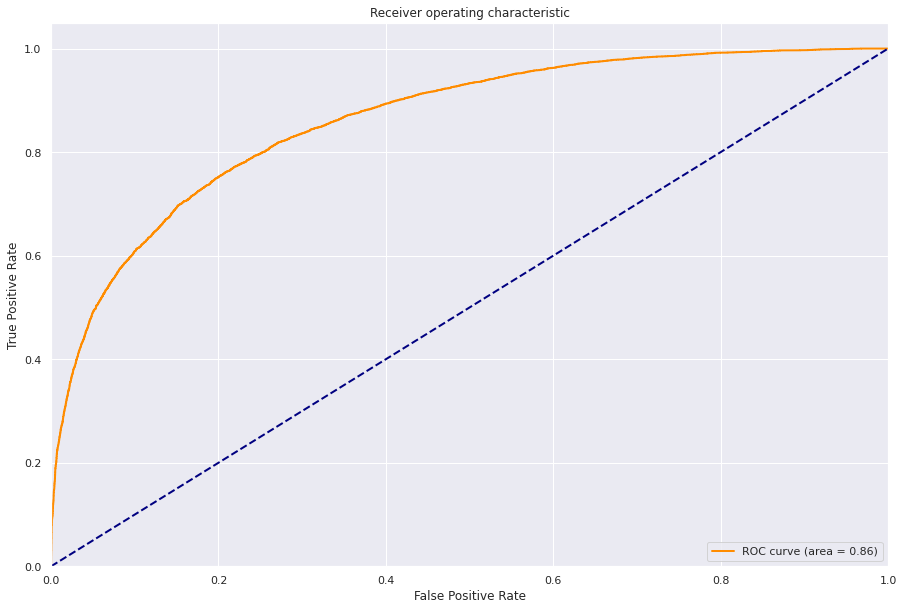

0.8615159288145584

In [13]:
fpr, tpr, thresholds = roc_curve(y_val, forest_final.predict_proba(x_val)[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_val, forest_final.predict_proba(x_val)[:, 1]))

Cubre un área levemente superior a la del árbol de clasificación solo. Su AUC score es significativamente bueno, un poco mayor al del arbol, como es de esperar por ser un ensamble de ese modelo.

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento de transformar todas las variables a numericas.

In [6]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])

nuevo_ds = aplicarOneHot(nuevo_ds)
nuevo_ds.drop('id', inplace=True, axis=1)

predicciones = forest_final.predict(nuevo_ds)
crear_archivo_predicciones(predicciones,"Random Forest",ids_registro)